# Graph Models and Hypothesis Testing

In this practical we will discover how use some simple models to generate synthetic networks and how we can use these models to test hypotheses about observed networks.

Some of the libraries are difficult to install on some systems, so it is best to open this notebook in Colab [![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jgarciab/NetworkScience/blob/main/Practicals/day2a_graph_models/Graph_models_and_hypothesis_testing_2024.ipynb)


You cannot save changes in this notebook, you need to save a copy to your Google Drive: `File` -> `Save a copy in Drive`.

First, we must install a useful library for analysing networks called [graph-tool](https://graph-tool.skewed.de/)...

In [ ]:
# Graph-tool is not available in the standard colab environment so we must first install it...
# %%capture
!wget https://downloads.skewed.de/skewed-keyring/skewed-keyring_1.0_all_$(lsb_release -s -c).deb
!dpkg -i skewed-keyring_1.0_all_$(lsb_release -s -c).deb
!echo "deb [signed-by=/usr/share/keyrings/skewed-keyring.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

# Colab uses a Python install that deviates from the system's! Bad colab! We need some workarounds.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Next we can import graph-tool and some other useful libraries.

In [2]:
import graph_tool.all as gt
from graph_tool import topology, inference, generation, stats, correlations
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import binomtest

### PART I: Regular and random networks

In the first part of this practical, we will consider some simple network models and the properties of the networks they generate.

The graph-tool documentation for these network models is [here](https://graph-tool.skewed.de/static/doc/generation.html). **It will be useful to refer to the documentation to understand and use the code below**

#### Regular graphs and lattices
Regular graphs are networks in which all nodes have the same degree ($k$).
A lattice graph is a network in which all the nodes are arranged in a regular pattern, such as a ring or a square. Lattice graphs are often regular as all nodes have the same degree, with the exception of boundary nodes.

The following code generates two examples of these types of graph: a square lattice ($k=4$, except boundary nodes) and a regular ring lattice ($k=2$)

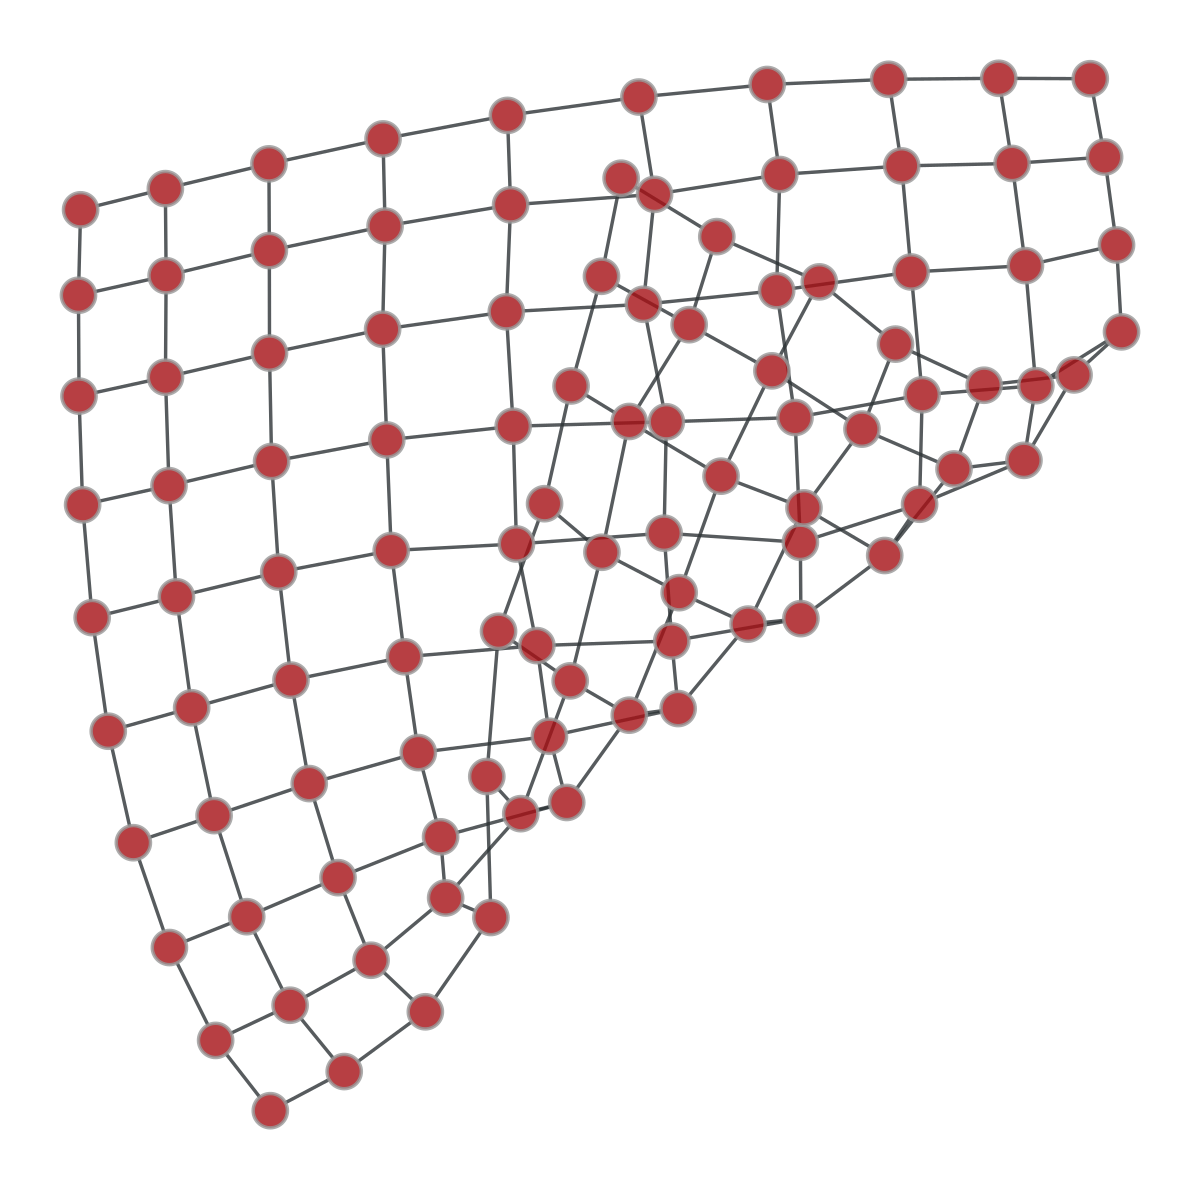

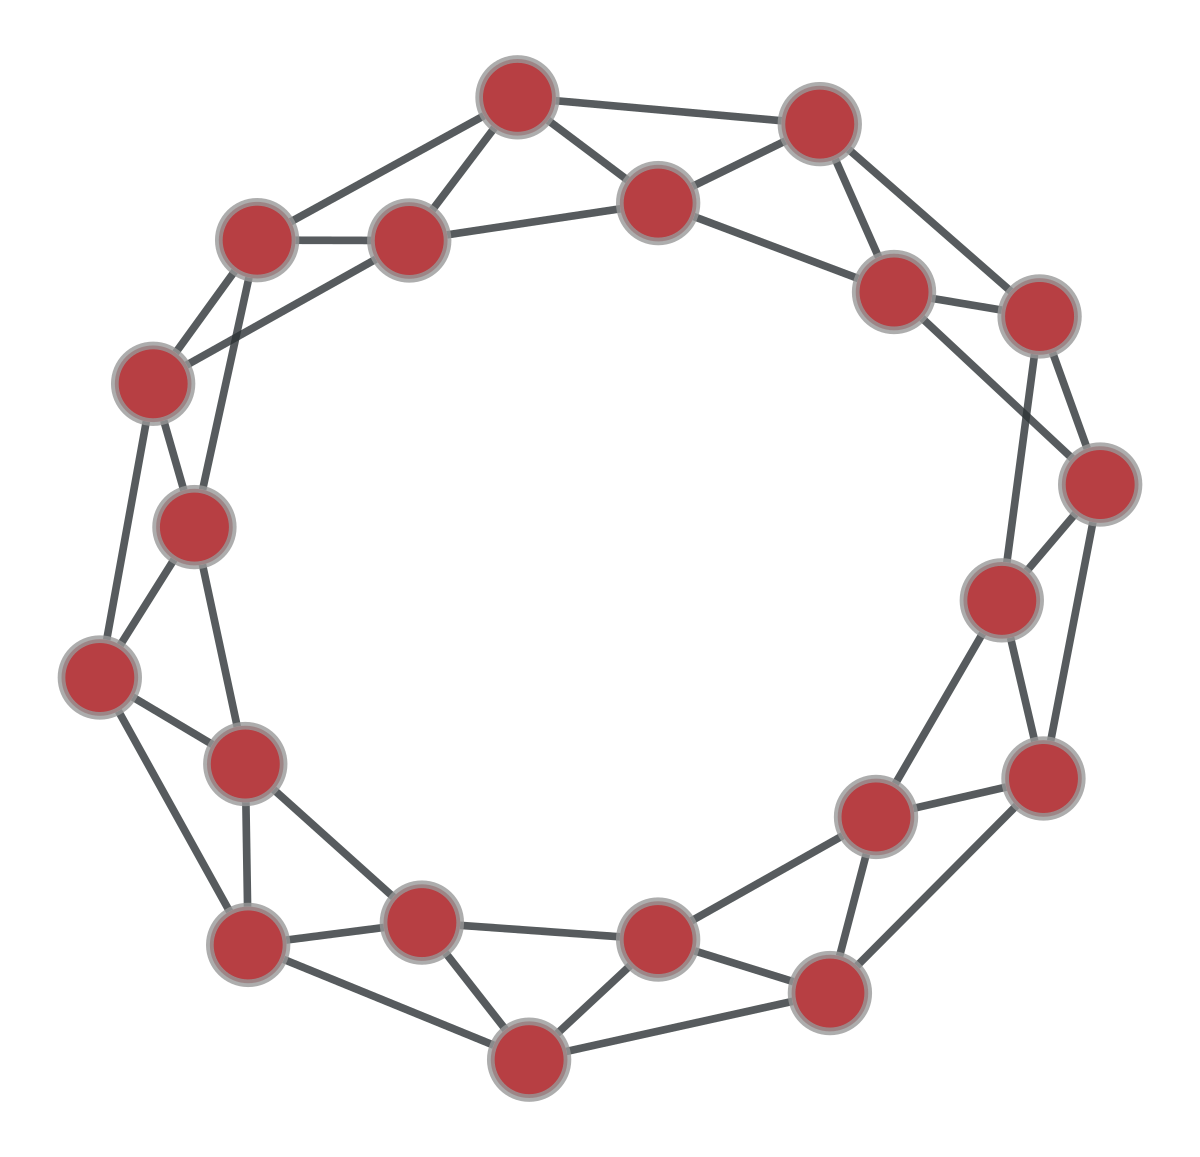

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f5e99567470, at 0x7f5e993fe180>

In [3]:
# generate square lattice
g = gt.lattice([10,10])
# create layout
pos = gt.sfdp_layout(g, cooling_step=0.95, epsilon=1e-2)
# draw the network
gt.graph_draw(g, pos=pos)

# generate ring lattice
g = gt.circular_graph(20, 2)
# create layout
pos = gt.sfdp_layout(g, cooling_step=0.95)
# draw the network
gt.graph_draw(g, pos=pos)

We know that regular graphs have constant degree. We can check the level of clustering (closed triangles) and average path length (diameter) using the following code:

In [4]:
# print the number of nodes and edges in the network
print('Number of nodes', g.num_vertices())
print('Number of edges', g.num_edges())
print('Clustering coefficient', gt.local_clustering(g).fa.mean())
# Note that calculating the average path length exactly can be computationally
# expensive for large networks, so here we use the pseudo diameter as an
# approximation
print('Average path length', gt.pseudo_diameter(g)[0])

Number of nodes 20
Number of edges 40
Clustering coefficient 0.5
Average path length 5.0


**Now try generating a ring lattice with 100 nodes and degree of 8 and calculate the average path length and clustering coefficient**

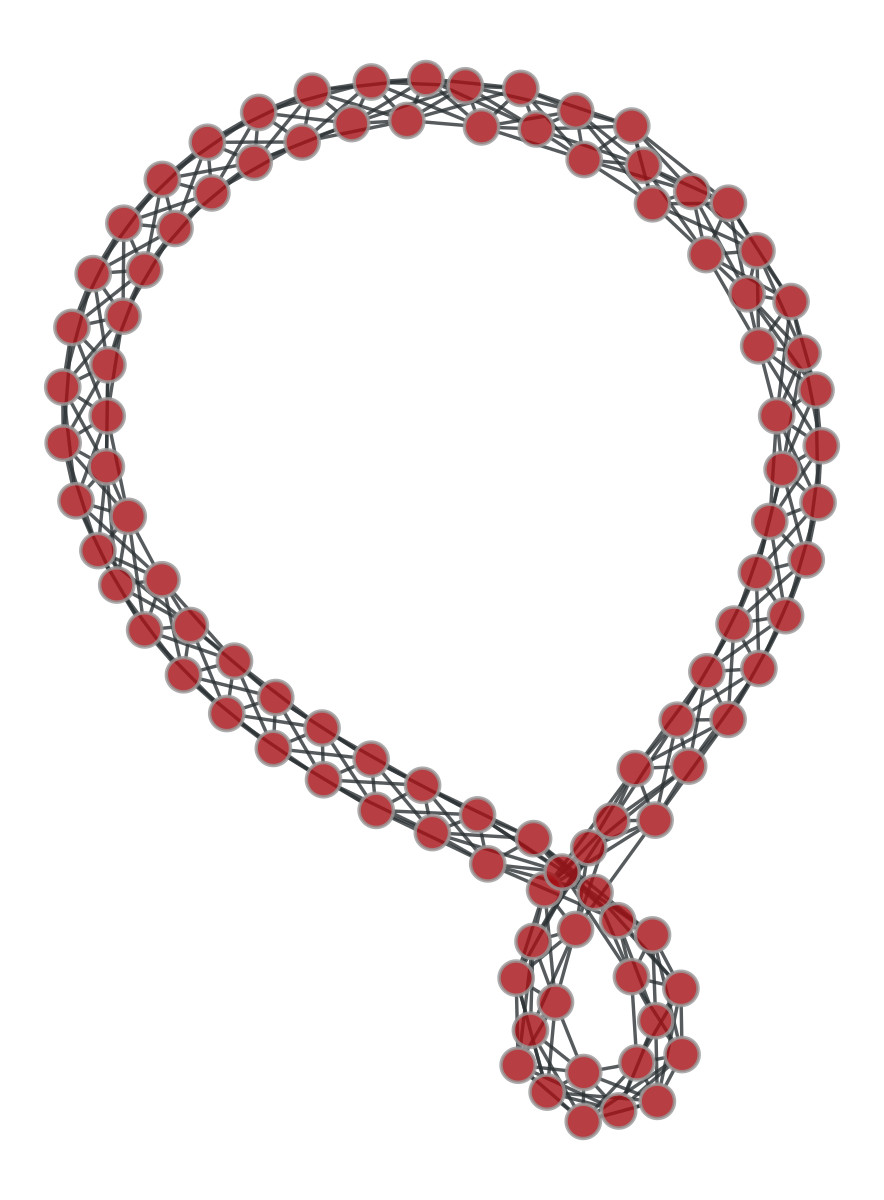

Number of nodes 100
Number of edges 400
Clustering coefficient 0.642857142857143
Average path length 13.0


In [5]:
## SOLUTION

# generate ring lattice
g = gt.circular_graph(100, 4)
# create layout
pos = gt.sfdp_layout(g, cooling_step=0.95)
# draw the network
gt.graph_draw(g, pos=pos)

print('Number of nodes', g.num_vertices())
print('Number of edges', g.num_edges())
print('Clustering coefficient', gt.local_clustering(g).fa.mean())
print('Average path length', gt.pseudo_diameter(g)[0])

### Random (Erdos-Renyi) graphs
Real-world networks tend to have more random connections than regular lattices. One of the simplest random graph models is the Erdos-Renyi model.

In the Erdos-Renyi model every pair of nodes has the same probablity of having a link between them.

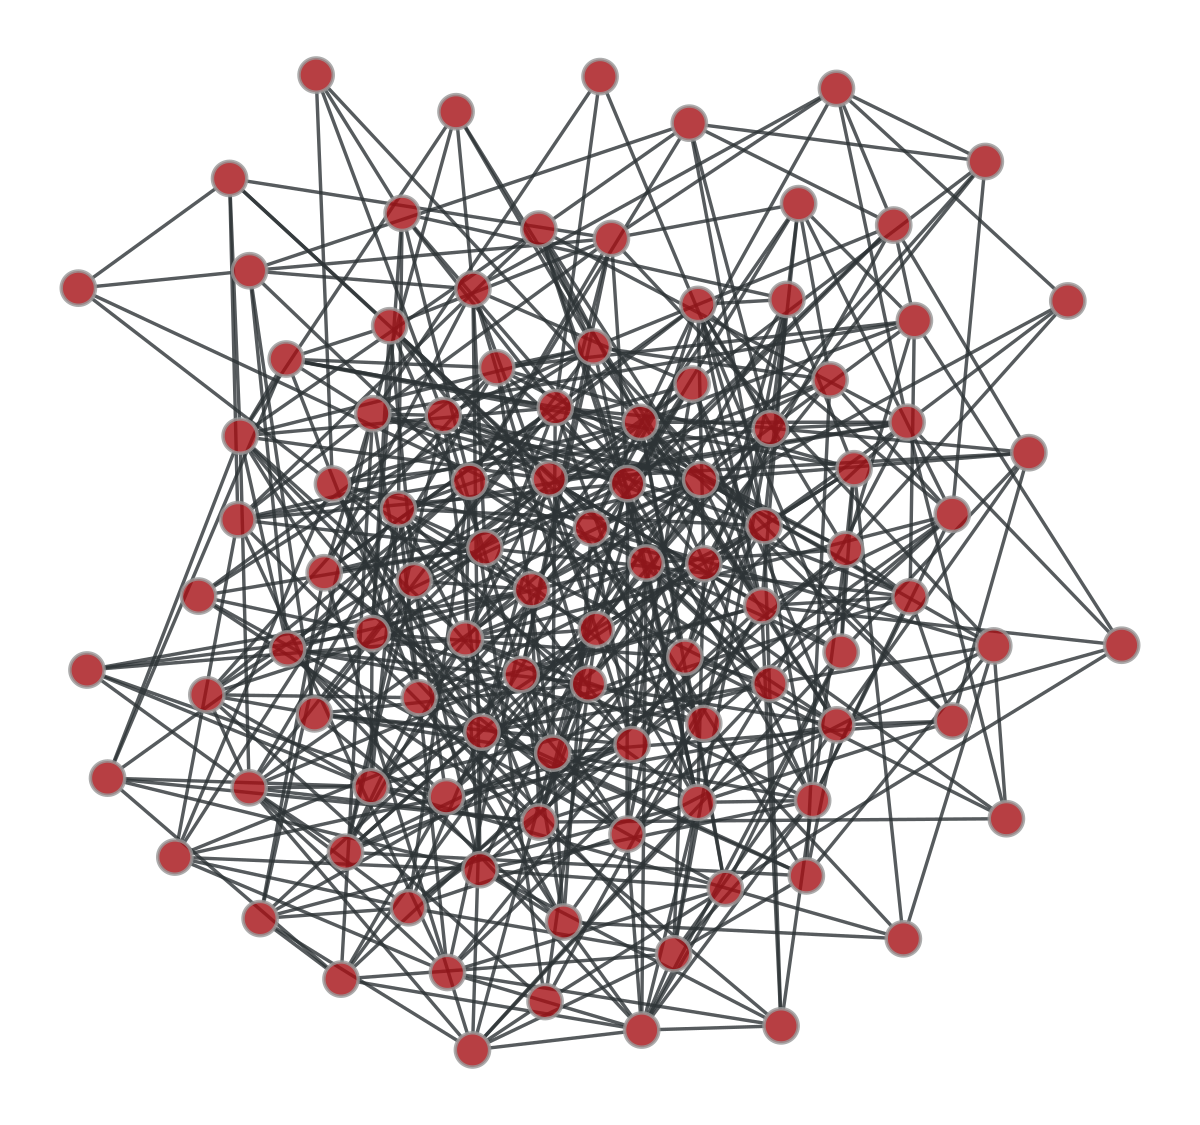

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f5e994834a0, at 0x7f5e9c7d9430>

In [6]:
g = gt.random_graph(100, lambda: np.random.poisson(10), directed=False)
gt.graph_draw(g)

**Compute and display the clustering coefficient, path length and degree distribution for this random graph. What do you notice?**

Number of nodes 100
Number of edges 501
Clustering coefficient 0.1030945345504169
Average path length 4.0


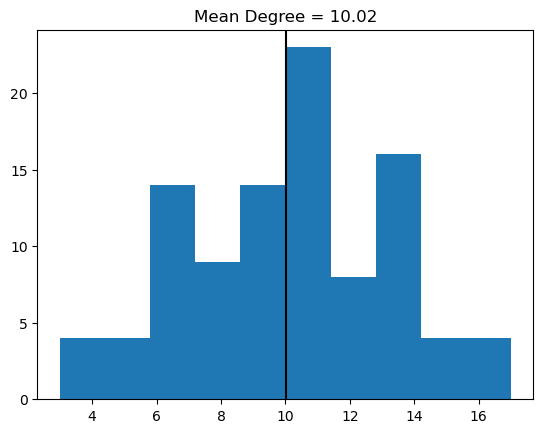

In [7]:
## SOLUTION

from math import degrees
print('Number of nodes', g.num_vertices())
print('Number of edges', g.num_edges())
print('Clustering coefficient', gt.local_clustering(g).fa.mean())
print('Average path length', gt.pseudo_diameter(g)[0])

# plot a histogram of the degrees
degree_sequence = g.get_total_degrees(list(g.vertices()))
_ = plt.hist(degree_sequence, bins=10)
_ = plt.axvline(np.mean(degree_sequence), color='black')
_ = plt.title('Mean Degree = {:.2f}'.format(np.mean(degree_sequence)))

**Generate another random graph with 1000 nodes with the same expected degree and plot the degree distribution**

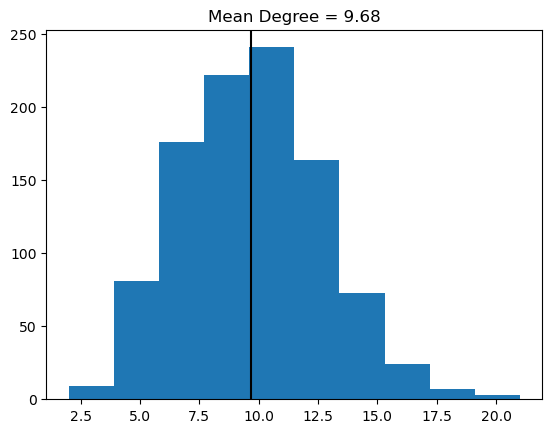

In [8]:
## SOLUTION

g1000 = gt.random_graph(1000, lambda: np.random.poisson(10), directed=False)

# plot a histogram of the degrees
degree_sequence = g1000.get_total_degrees(list(g1000.vertices()))
_ = plt.hist(degree_sequence, bins=10)
_ = plt.axvline(np.mean(degree_sequence), color='black')
_ = plt.title('Mean Degree = {:.2f}'.format(np.mean(degree_sequence)))

We use the binomial distribution to determine the probability of observing a node with a degree of 15 or more.

In [9]:
# number of nodes
n = 1000
# mean degree
c = 10
# probability of a connection
p = c/(n-1)
# probability of a node having at least 15 connections
test = binomtest(15, n-1, p, alternative='greater')
test.pvalue

0.08241126768378489

**How many nodes are there in the network at least 15 connections?**

**How many nodes would you expect to have a degree of at least 15?**

In [13]:
## SOLUTION

print(f'The network has {sum(degree_sequence>=15)} nodes with at least 15 connections.')
print(f'In a network with {n} nodes and mean degree {c} we would expect {n*test.pvalue:.1f} nodes with at least 15 connections.')

The network has 68 nodes with at least 15 connections.
In a network with 1000 nodes and mean degree 10 we would expect 82.4 nodes with at least 15 connections.


The code below loads a network in face-to-face interactions between high school students during the first hour of the school day.

In [14]:
!wget https://networks.skewed.de/net/sp_high_school/files/proximity.gt.zst
g_proximity = gt.load_graph("proximity.gt.zst", )

# create a graph view of the interactions in the first hour of the dataset
g_prox_hour1 = gt.GraphView(g_proximity, efilt = lambda e: g_proximity.ep.time[e] <= 1385982020 + 3600)


--2024-07-15 22:47:58--  https://networks.skewed.de/net/sp_high_school/files/proximity.gt.zst
Resolving networks.skewed.de (networks.skewed.de)... 49.12.93.194
Connecting to networks.skewed.de (networks.skewed.de)|49.12.93.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205530 (201K) [application/zstd]
Saving to: ‘proximity.gt.zst.2’

proximity.gt.zst.2  100%[===================>] 200.71K  --.-KB/s    in 0.09s   

2024-07-15 22:47:58 (2.08 MB/s) - ‘proximity.gt.zst.2’ saved [205530/205530]



**Considering the degree distribution, can you perform a statistical test to show that the interaction patterns are not modelled well with a ER random graph?**

Number of nodes 329
Number of nodes with at least 100 connections 33


BinomTestResult(k=100, n=328, alternative='greater', statistic=0.3048780487804878, pvalue=1.9834718302110586e-22)

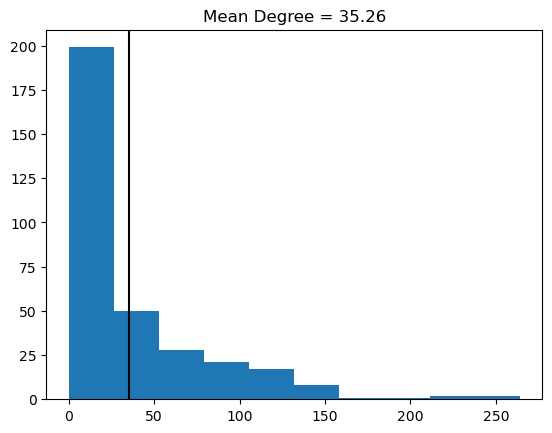

In [15]:
## SOLUTION

degree_sequence = g_prox_hour1.get_total_degrees(list(g_prox_hour1.vertices()))
_ = plt.hist(degree_sequence, bins=10)
_ = plt.axvline(np.mean(degree_sequence), color='black')
_ = plt.title('Mean Degree = {:.2f}'.format(np.mean(degree_sequence)))

p = np.mean(degree_sequence)/(g_proximity.num_vertices()-1)
print('Number of nodes', g_proximity.num_vertices())

print('Number of nodes with at least 100 connections', sum(degree_sequence>=100))

binomtest(100, g_proximity.num_vertices()-1, p, alternative='greater')

**Can you perform the same sort of tests using the clustering coefficient?**

In [261]:
## SOLUTION


### PART II: Small worlds and heavy tails

In the first part of this practical, we will consider some simple network models and the properties of the networks they generate.

The graph-tool documentation for these network models is [here](https://graph-tool.skewed.de/static/doc/generation.html). **It will be useful to refer to the documentation to understand and use the code below**

Recall from the lecture that there are a number of properties that real-world networks often exhibit:

1.   High clustering
2.   Short path lengths
3.   Heavy-tailed degree distributions

We will see that the following network models capture these properties to varying extents.

### Small-world networks

Small-world networks are networks that share properties of regular networks and random networks. Small-world networks are created by randomising a proportion of the links in a regular network, while preserving part of the regular structure.

![image.png](https://drive.google.com/uc?id=1P8ewNjJuGlnIvZp1RKF2WCQwAFaZ8AL5)



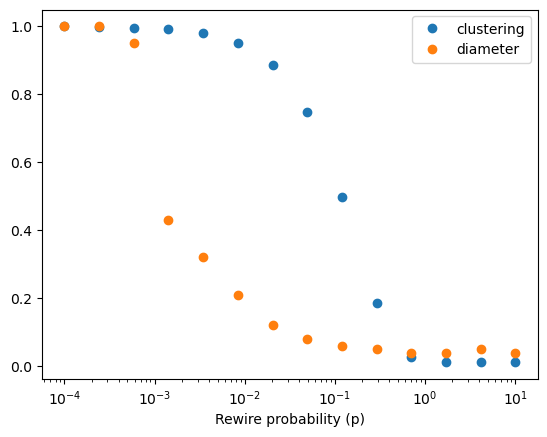

In [16]:
n_networks = 14
rewire_probs = np.logspace(-4, 1, n_networks)
n_nodes = 1000
n_edges = 5000
g = gt.circular_graph(n_nodes, n_edges/n_nodes)

C0 = gt.global_clustering(g)[0]
L0 = gt.pseudo_diameter(g)[0]

clusts = np.empty(n_networks)
lengths = np.empty(n_networks)

for i in range(n_networks):
  # generate ring lattice
  g = gt.circular_graph(n_nodes, n_edges/n_nodes)
  p = rewire_probs[i]
  generation.random_rewire(g, n_iter=np.round(p*n_edges), edge_sweep=False)
  clusts[i] = gt.global_clustering(g)[0]/C0
  lengths[i] = gt.pseudo_diameter(g)[0]/L0

plt.semilogx(rewire_probs, clusts, 'o', label='clustering')
plt.semilogx(rewire_probs, lengths, 'o', label='diameter')
plt.legend()
_ = plt.xlabel('Rewire probability (p)')


**What range of $p$ produces "realistic" networks?**

### The Price Model (preferential attachment)

The models so far capture some important properties commonly observed in real-world networks, however they all create networks with a relatively homogenous degree distribution.

The Price model (or Barabási-Albert model, if undirected) creates networks based on a mechanism known as preferential attachment.

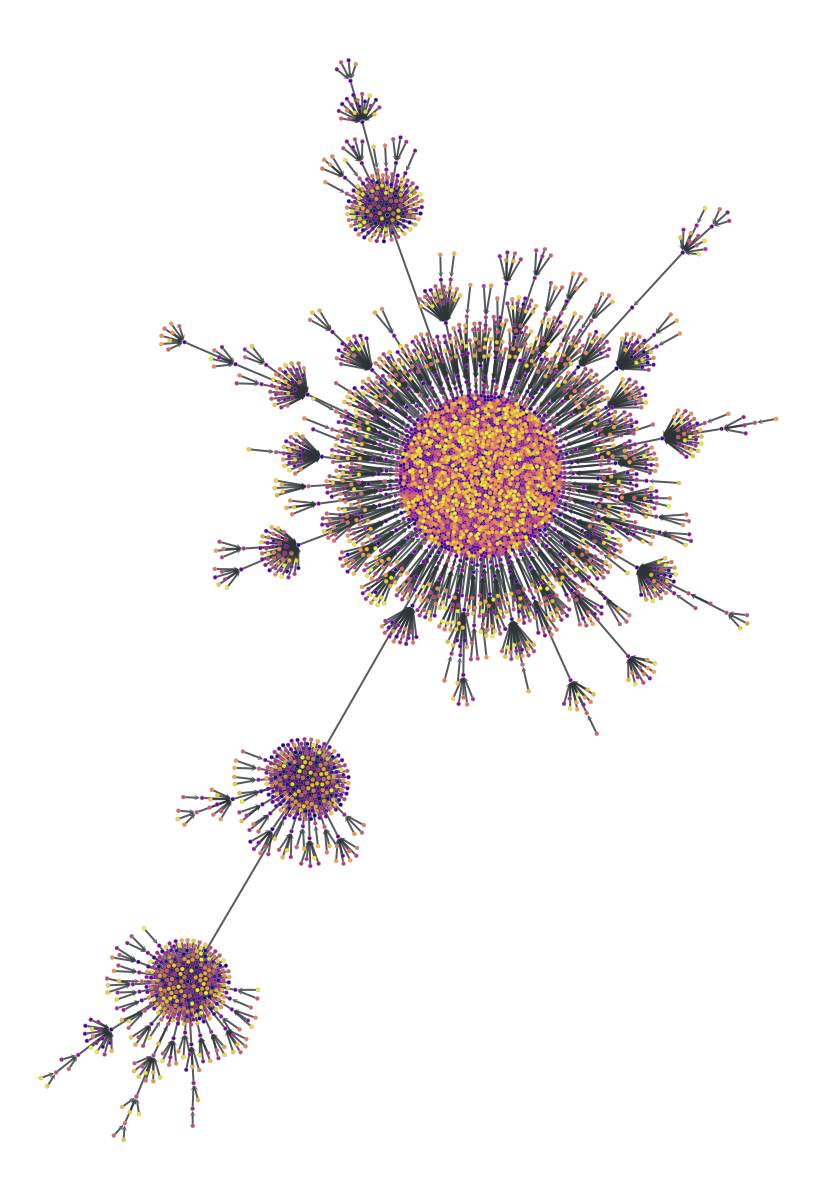

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f5e983696d0, at 0x7f5f0968d6a0>

In [17]:
g = gt.price_network(5000)

gt.graph_draw(g, pos=gt.sfdp_layout(g, cooling_step=0.99),
              vertex_fill_color=g.vertex_index, vertex_size=2,
              vcmap=mpl.cm.plasma,
              edge_pen_width=1)

Above the colours indicate the order in which the nodes were added to the network.

We can now plot the degree distribution on a log-log axes...

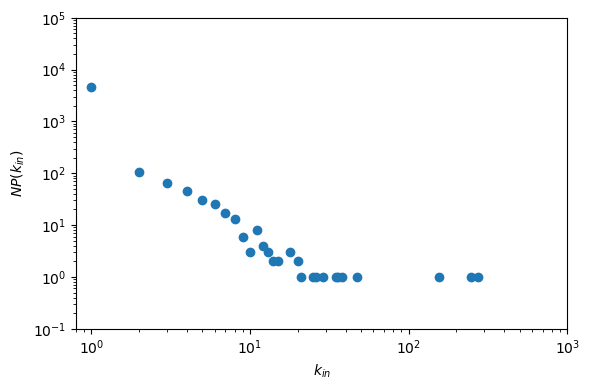

In [20]:
# Let's plot the degree distribution
in_hist = gt.vertex_hist(g, "total")

y = in_hist[0]
err = np.sqrt(in_hist[0])
err[err >= y] = y[err >= y] - 1e-2

plt.figure(figsize=(6,4))

plt.errorbar(in_hist[1][:-1], in_hist[0], fmt="o", yerr=0, label="in")

plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.gca().set_ylim(1e-1, 1e5)
plt.gca().set_xlim(0.8, 1e3)
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.xlabel("$k_{in}$")
plt.ylabel("$NP(k_{in})$")
plt.tight_layout()

### The configuration model

The configuration model is an extention of the random graph model in which an arbitrary degree sequence can be specified.

We can generate a configuration model network using the `random_graph` function in graph-tool, by specifying a function that generates a heavy-tailed distribution to set the node degrees.

However, an alternative is to use a network that already has a heavy-tailed degree sequence and rewire the edges such that the degrees are preserved.

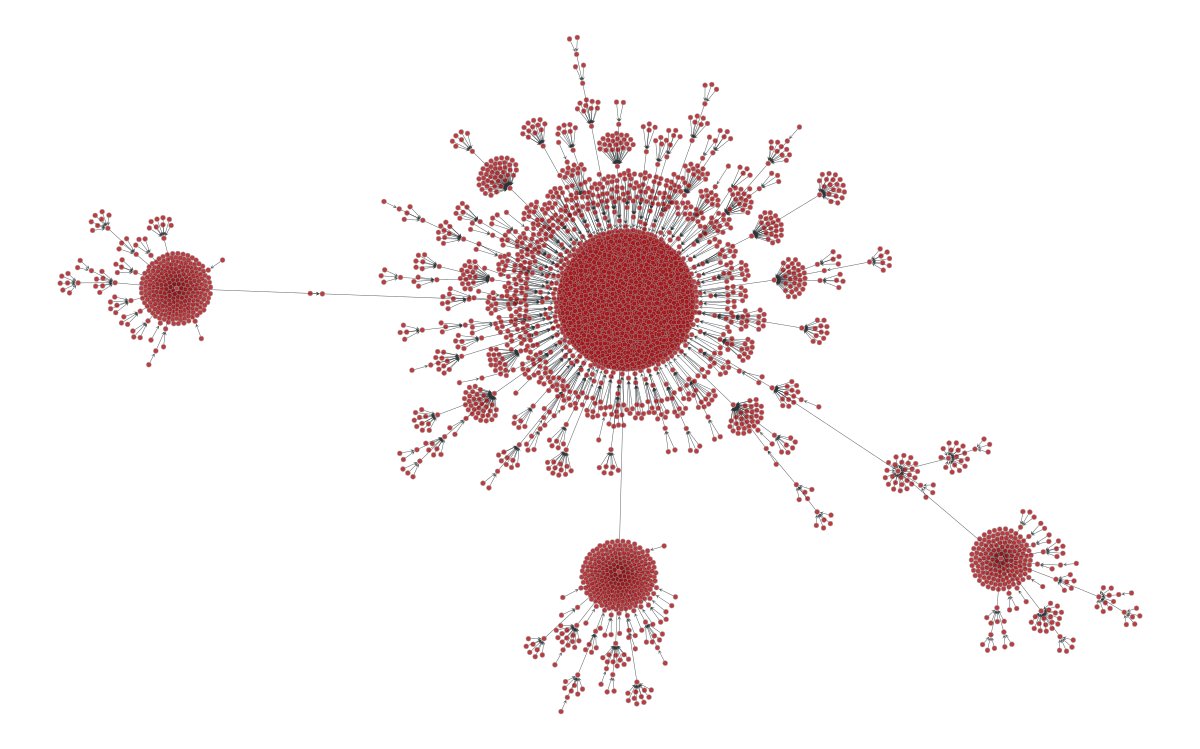

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f5e983696d0, at 0x7f5e983993a0>

In [21]:
generation.random_rewire(g, model='configuration')
gt.graph_draw(g)

### The Friendship paradox

**Test the proxmity network from earlier to determine if the friendship paradox holds.**

In [23]:
# load the data and remove parallel edges
g_proximity = gt.load_graph("proximity.gt.zst", )
gt.remove_parallel_edges(g_proximity)

## SOLUTION

# create an adjacency matrix
A = gt.adjacency(g_proximity)
# calculate a vector of degrees
k = np.sum(A, axis=1)
# calculate the mean of friends degrees
friend_degrees = A.dot(k)/k
# compare with the actual degrees
popular_nodes = sum(k > friend_degrees) / len(k)
print('The proportion of nodes that have more friends than their average friend is', popular_nodes)

The proportion of nodes that have more friends than their average friend is [[0.32522796]]


/tmp/ipykernel_9237/3242088689.py:12: RuntimeWarning: invalid value encountered in divide
  friend_degrees = A.dot(k)/k


### PART III: The BESTest

The following gives an example on how to run the BESTest on the Lazega lawyers networks. Try out the code for yourself.

In [24]:
# function to get entropy of a random partition
def random_entropy(g, n_groups):

  n = g.num_vertices()
  b = np.random.randint(n_groups, size=n)
  vprop_b = g.new_vertex_property("int")
  for i in range(n):
    v = g.vertex(i)
    vprop_b[v] = b[i]

  state = gt.BlockState(g, b=vprop_b)
  return state.entropy()


In [25]:
!wget 'https://github.com/jgarciab/NetworkScience/raw/main/Data/law_firm.gt.zst'
g = gt.load_graph('law_firm.gt.zst')

--2024-07-15 23:12:13--  https://github.com/jgarciab/NetworkScience/raw/main/Data/law_firm.gt.zst
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jgarciab/NetworkScience/main/Data/law_firm.gt.zst [following]
--2024-07-15 23:12:13--  https://raw.githubusercontent.com/jgarciab/NetworkScience/main/Data/law_firm.gt.zst
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4352 (4.2K) [application/octet-stream]
Saving to: ‘law_firm.gt.zst’

law_firm.gt.zst     100%[===================>]   4.25K  --.-KB/s    in 0s      

2024-07-15 23:12:13 (15.6 MB/s) - ‘law_firm.gt.zst’ saved [4352/4352]



In [26]:
# create a graph with layer 1
u = gt.GraphView(g, efilt=lambda e: g.ep.layer[e] == 1)
g1 = gt.Graph(u, prune=True)
print(list(g1.vp.keys()))

['name', 'nodeStatus', 'nodeGender', 'nodeOffice', 'nodeSeniority', 'nodeAge', 'nodePractice', 'nodeLawSchool', '_pos']


In [27]:
attr_name = 'nodeOffice'
state = gt.BlockState(g1, b=g1.vp[attr_name])
test_value = state.entropy()
print('observed test statistic (entropy)', test_value)

observed test statistic (entropy) 2271.0064282744397


In [28]:
n_samples = 1000
n_groups = len(set(g1.vp[attr_name]))
null_entropy = np.empty(n_samples)
for i in range(n_samples):
  null_entropy[i] = random_entropy(g1, n_groups)

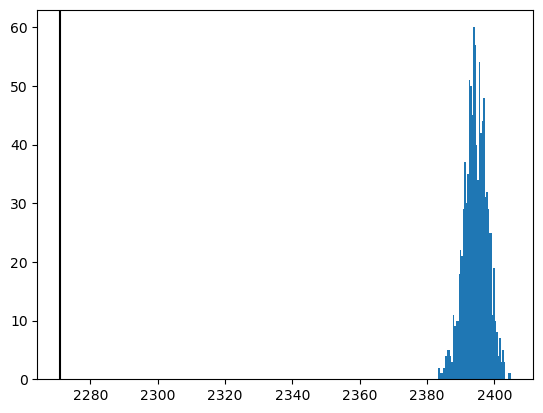

In [29]:
plt.hist(null_entropy, bins=50)
_ = plt.axvline(test_value, color='black')

**Can you also run the BESTest on the proximity network?**

### Part IV: Reconstructing networks from noisy data

In [32]:
# load the data and remove parallel edges
g_proximity = gt.load_graph("proximity.gt.zst", )
gt.remove_parallel_edges(g_proximity)



**Try rewiring the edges to introduce some "noise" into the network structure. What happens to the clustering coefficient, path length and assortativity?**

In [34]:
## SOLUTION

# make a copy of the graph to add noise
g_proximity_with_noise = g_proximity.copy()

# calculate the clustering coefficient
clustering = np.empty(50)
clustering[0] = gt.local_clustering(g_proximity_with_noise).fa.mean()
# calculate the average path length
diameter = np.empty(50)
diameter[0] = gt.pseudo_diameter(g_proximity_with_noise)[0]
# calculate the assortativity
assortativity = np.empty(50)
assortativity[0] = correlations.assortativity(g_proximity_with_noise, 'total')[0]

print('Clustering coefficient', clustering[0])
print('Average path length', diameter[0])
print('Assortativity', assortativity[0])


for i in range(1, 50):
    # generation.add_random_edges(g_proximity, 10)
    generation.random_rewire(g_proximity_with_noise, n_iter=100, edge_sweep=False)
    # calculate the clustering coefficient
    clustering[i] = gt.global_clustering(g_proximity_with_noise)[0]
    # calculate the average path length
    diameter[i] = gt.pseudo_diameter(g_proximity_with_noise)[0]
    # calculate the assortativity
    assortativity[i] = correlations.assortativity(g_proximity_with_noise, 'total')[0]

    print('\nIteration', i)
    print('Clustering coefficient', clustering[i])
    print('Average path length', diameter[i])
    print('Assortativity', assortativity[i])


Clustering coefficient 0.5004439996034051
Average path length 4.0
Assortativity -0.004084602652156313

Iteration 1
Clustering coefficient 0.41656385147859065
Average path length 4.0
Assortativity -0.00390807582327935

Iteration 2
Clustering coefficient 0.3926674372394447
Average path length 4.0
Assortativity -0.004084602652156313

Iteration 3
Clustering coefficient 0.37032948479850386
Average path length 4.0
Assortativity -0.004084602652156313

Iteration 4
Clustering coefficient 0.3499006480603644
Average path length 4.0
Assortativity -0.004614183138787196

Iteration 5
Clustering coefficient 0.3322380810140391
Average path length 4.0
Assortativity -0.00390807582327935

Iteration 6
Clustering coefficient 0.3144975908778036
Average path length 4.0
Assortativity -0.004261129481033273

Iteration 7
Clustering coefficient 0.3002896141508331
Average path length 4.0
Assortativity -0.0037315489944023893

Iteration 8
Clustering coefficient 0.28645826569176225
Average path length 4.0
Assortativit

Now we will attempt to reconstruct the network from a noisy version.

First we generate a noisy version by rewiring 100 edges...

In [37]:
# make a copy of the graph to add noise
g_proximity_with_noise = g_proximity.copy()
generation.random_rewire(g_proximity_with_noise, n_iter=100, edge_sweep=False)

# calculate the similarity between the original and the noisy graph
similarity = topology.similarity(g_proximity, g_proximity_with_noise)
print('Similarity', similarity)

# calculate clustering coefficient of original and noisy graph
clustering = gt.local_clustering(g_proximity).fa.mean()
clustering_with_noise = gt.local_clustering(g_proximity_with_noise).fa.mean()
print('Clustering coefficient', clustering)
print('Clustering coefficient with noise', clustering_with_noise)


Similarity 0.9737023031969749
Clustering coefficient 0.5004439996034051
Clustering coefficient with noise 0.46813741957484734


Now we attempt the reconstruction:

In [203]:
n = g_proximity_with_noise.new_ep("int", 1)   # number of measurements
x = g_proximity_with_noise.new_ep("int", 1)   # number of observations

# We inititialize MeasuredBlockState, assuming that each non-edge has
# been measured only once (n_default=1) and not observed (x_default=0)

state = gt.MeasuredBlockState(g_proximity_with_noise, n=n, n_default=1, x=x, x_default=0)

# We will first equilibrate the Markov chain
gt.mcmc_equilibrate(state, wait=100, mcmc_args=dict(niter=10))

# Now we collect the marginals for exactly 100,000 sweeps, at
# intervals of 10 sweeps:

u = None              # marginal posterior edge probabilities
bs = []               # partitions
cs = []               # average local clustering coefficient

def collect_marginals(s):
   global u, bs, cs
   u = s.collect_marginal(u)
   bstate = s.get_block_state()
   bs.append(bstate.levels[0].b.a.copy())
   cs.append(gt.local_clustering(s.get_graph()).fa.mean())

gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_marginals)

eprob = u.ep.eprob
print("Estimated average local clustering: %g ± %g" % (np.mean(cs), np.std(cs)))

g_inferred = gt.GraphView(u, efilt = lambda e: u.ep.eprob[e] >= 0.5)
similarity = topology.similarity(g_proximity, g_inferred)
print('Similarity', similarity)


Estimated average local clustering: 0.509914 ± 0.0127198


(array([182690.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   5818.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

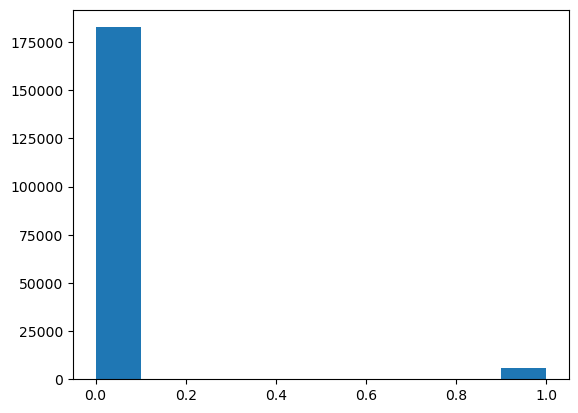

In [55]:
g_proximity_with_noise = g_proximity.copy()
generation.random_rewire(g_proximity_with_noise, n_iter=100, edge_sweep=False)

n_obs = 1
n = g_proximity_with_noise.new_ep("int", n_obs)   # number of measurements
x = g_proximity_with_noise.new_ep("int", 1)   # number of observations

plt.hist(x.a)

(array([181267.,      0.,      0.,      0.,      0.,   2846.,      0.,
             0.,      0.,   4395.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

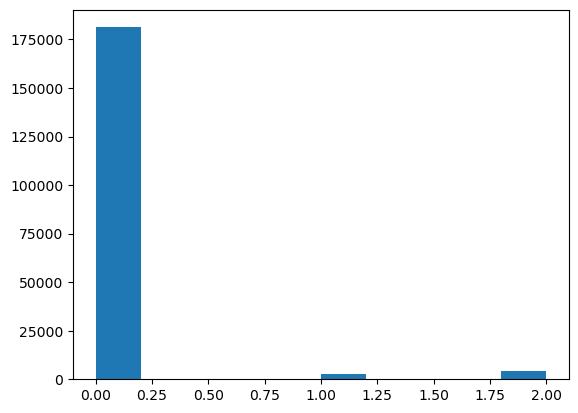

In [56]:

g_proximity_with_noise1 = g_proximity.copy()
generation.random_rewire(g_proximity_with_noise1, n_iter=1000, edge_sweep=False)

x1 = g_proximity_with_noise1.new_ep("int", 1)

for edge in g_proximity_with_noise1.edges():
    try:
        x[(edge.source(), edge.target())] += 1
        n[(edge.source(), edge.target())] += 1

    except IndexError:
        g_proximity_with_noise.add_edge(edge.source(), edge.target())
        x[(edge.source(), edge.target())] = 1

n_obs += 1

plt.hist(x.a)

In [57]:
n = g_proximity_with_noise.new_ep("int", n_obs)   # number of measurements

state = gt.MeasuredBlockState(g_proximity_with_noise, n=n, n_default=n_obs, x=x, x_default=0)

# We will first equilibrate the Markov chain
gt.mcmc_equilibrate(state, wait=100, mcmc_args=dict(niter=10))

# Now we collect the marginals for exactly 100,000 sweeps, at
# intervals of 10 sweeps:

u = None              # marginal posterior edge probabilities
bs = []               # partitions
cs = []               # average local clustering coefficient

def collect_marginals(s):
   global u, bs, cs
   u = s.collect_marginal(u)
   bstate = s.get_block_state()
   bs.append(bstate.levels[0].b.a.copy())
   cs.append(gt.local_clustering(s.get_graph()).fa.mean())

gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_marginals)

eprob = u.ep.eprob
print("Estimated average local clustering: %g ± %g" % (np.mean(cs), np.std(cs)))

g_inferred = gt.GraphView(u, efilt = lambda e: u.ep.eprob[e] >= 0.5)
similarity = topology.similarity(g_proximity, g_inferred)
print('Similarity', similarity)


0.9479202475077346